<a href="https://colab.research.google.com/github/yukiharada1228/MPRGDeepLearningLectureNotebook/blob/master/Introduction_to_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optuna入門
- ハイパーパラメータ自動最適化フレームワークOptuna
    - 株式会社Preferred Networksがオープンソースで提供するハイパーパラメータ自動最適化フレームワークです．
    - 深層学習フレームワークChainer，Pytorchをはじめ、様々な機械学習ソフトウェアと一緒に使用することが可能です．

## インストール
- pipコマンドでOptunaをGoogle Colaboratoryに導入します．

In [ ]:
!pip -q install optuna==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.2 MB/s eta 0:00:00


## 2次関数の最小値探索
 - yを最小化させるxをハイパーパラメータとしてOptunaで探索します．
### 例）
$$ y = (x - 5)^2 + 25 $$

[I 2023-04-08 05:26:12,578] A new study created in memory with name: no-name-1d3c67b9-5b01-466a-93c3-cc0ba67547eb
[I 2023-04-08 05:26:12,584] Trial 0 finished with value: 40.210000000000015 and parameters: {'x': 8.900000000000002}. Best is trial 0 with value: 40.210000000000015.
[I 2023-04-08 05:26:12,587] Trial 1 finished with value: 196.60999999999999 and parameters: {'x': -8.1}. Best is trial 0 with value: 40.210000000000015.
[I 2023-04-08 05:26:12,589] Trial 2 finished with value: 148.20999999999998 and parameters: {'x': -6.1}. Best is trial 0 with value: 40.210000000000015.
[I 2023-04-08 05:26:12,592] Trial 3 finished with value: 59.81 and parameters: {'x': -0.9000000000000004}. Best is trial 0 with value: 40.210000000000015.
[I 2023-04-08 05:26:12,594] Trial 4 finished with value: 25.09 and parameters: {'x': 4.700000000000001}. Best is trial 4 with value: 25.09.
[I 2023-04-08 05:26:12,596] Trial 5 finished with value: 35.239999999999995 and parameters: {'x': 1.8000000000000007}. 

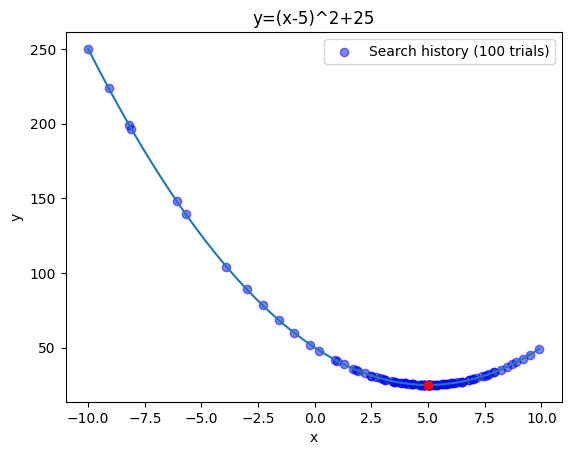

最適なパラメータ: x=5.0
最小値: y=25.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

# 最適化する関数を定義
def y(x):
    return (x - 5)**2 + 25

# xの値域を定義
x_range = np.arange(-10, 10, 0.1)

# yの値域を計算
y_range = [y(x) for x in x_range]

# Optunaによる最小化問題を定義
def objective(trial):
    x = trial.suggest_float('x', -10, 10, step=0.1)  # xを連続値で指定し、stepを指定して0.1刻みにする
    return y(x)

# Optunaで探索
study = optuna.create_study()
study.optimize(objective, n_trials=100)  # 探索回数を指定

# 最適なxを取得し、最小値を計算
x_opt = study.best_params['x']  # 最適なxを取得
y_opt = y(x_opt)  # 最適なxでのyを計算

# Optunaによる探索履歴を取得
opt_x = [t.params['x'] for t in study.trials]  # 各試行のxの値をリストにまとめる
opt_y = [t.value for t in study.trials]  # 各試行の目的関数の値をリストにまとめる

# グラフを描画
plt.plot(x_range, y_range)
plt.xlabel('x')
plt.ylabel('y')
plt.title('y=(x-5)^2+25')

# 探索履歴をプロット
plt.scatter(opt_x, opt_y, c='b', alpha=0.5, label=f'Search history ({len(opt_x)} trials)')  # 探索履歴をプロット

# 最適なxの場所に点を打つ
plt.plot(x_opt, y_opt, 'ro')

plt.legend()
plt.show()

print(f"最適なパラメータ: x={x_opt}")  # 最適なパラメータを表示
print(f"最小値: y={y_opt}")  # 最小値を表示

## MLPのハイパーパラメータ探索

In [ ]:
import tensorflow as tf
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def create_model(trial):
    model = keras.Sequential()

    # 各層のユニット数と層の数を調整する
    n_layers = trial.suggest_int('n_layers', 1, 5)
    for i in range(n_layers):
        n_units = trial.suggest_int('n_units_l{}'.format(i), 4, 128, log=True)
        model.add(keras.layers.Dense(units=n_units, activation='relu'))

    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # オプティマイザの学習率を調整する
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

def objective(trial):
    model = create_model(trial)

    # モデルの訓練
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=128)

    # テストデータでモデルを評価する
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best accuracy:', study.best_trial.value)

[I 2023-04-08 05:27:22,709] A new study created in memory with name: no-name-1c4543fe-7e88-4462-9676-cfd44f8eeb83


Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 0.8738 - accuracy: 0.7093 - val_loss: 0.4929 - val_accuracy: 0.8675
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4356 - accuracy: 0.8804 - val_loss: 0.4089 - val_accuracy: 0.8941
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3586 - accuracy: 0.9050 - val_loss: 0.3580 - val_accuracy: 0.9098
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3091 - accuracy: 0.9184 - val_loss: 0.3020 - val_accuracy: 0.9220
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2472 - accuracy: 0.9322 - val_loss: 0.2678 - val_accuracy: 0.9272
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2208 - accuracy: 0.9376 - val_loss: 0.2401 - val_accuracy: 0.9354
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2001 - accuracy: 0.9434 - val_loss: 0.2398 - val_accuracy: 0.9360
Epoch 

[I 2023-04-08 05:28:01,594] Trial 0 finished with value: 0.9437000155448914 and parameters: {'n_layers': 2, 'n_units_l0': 21, 'n_units_l1': 4, 'learning_rate': 0.005458778284598513}. Best is trial 0 with value: 0.9437000155448914.


Epoch 1/20
469/469 [==============================] - 4s 4ms/step - loss: 0.8942 - accuracy: 0.7198 - val_loss: 0.4080 - val_accuracy: 0.8882
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3419 - accuracy: 0.9044 - val_loss: 0.2888 - val_accuracy: 0.9173
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2650 - accuracy: 0.9253 - val_loss: 0.2406 - val_accuracy: 0.9294
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2255 - accuracy: 0.9363 - val_loss: 0.2256 - val_accuracy: 0.9344
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2001 - accuracy: 0.9424 - val_loss: 0.1989 - val_accuracy: 0.9399
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1815 - accuracy: 0.9465 - val_loss: 0.1880 - val_accuracy: 0.9431
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1677 - accuracy: 0.9506 - val_loss: 0.1877 - val_accuracy: 0.9433
Epoch 

[I 2023-04-08 05:29:32,951] Trial 1 finished with value: 0.9573000073432922 and parameters: {'n_layers': 3, 'n_units_l0': 31, 'n_units_l1': 6, 'n_units_l2': 35, 'learning_rate': 0.0006114924629574203}. Best is trial 1 with value: 0.9573000073432922.


Epoch 1/20
469/469 [==============================] - 4s 4ms/step - loss: 0.2513 - accuracy: 0.9226 - val_loss: 0.1326 - val_accuracy: 0.9588
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1287 - accuracy: 0.9609 - val_loss: 0.1243 - val_accuracy: 0.9626
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1039 - accuracy: 0.9690 - val_loss: 0.1112 - val_accuracy: 0.9670
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0874 - accuracy: 0.9740 - val_loss: 0.1080 - val_accuracy: 0.9692
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0805 - accuracy: 0.9762 - val_loss: 0.1095 - val_accuracy: 0.9716
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 0.1176 - val_accuracy: 0.9697
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0646 - accuracy: 0.9810 - val_loss: 0.1613 - val_accuracy: 0.9653
Epoch 

[I 2023-04-08 05:30:13,903] Trial 2 finished with value: 0.9711999893188477 and parameters: {'n_layers': 3, 'n_units_l0': 82, 'n_units_l1': 61, 'n_units_l2': 35, 'learning_rate': 0.008173462174048737}. Best is trial 2 with value: 0.9711999893188477.


Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 2.0629 - accuracy: 0.2434 - val_loss: 1.7758 - val_accuracy: 0.3964
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 1.5538 - accuracy: 0.5022 - val_loss: 1.3405 - val_accuracy: 0.5944
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 1.2079 - accuracy: 0.6296 - val_loss: 1.0687 - val_accuracy: 0.6808
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.9932 - accuracy: 0.7057 - val_loss: 0.8945 - val_accuracy: 0.7471
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.8479 - accuracy: 0.7578 - val_loss: 0.7725 - val_accuracy: 0.7893
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7455 - accuracy: 0.7913 - val_loss: 0.6867 - val_accuracy: 0.8088
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.6711 - accuracy: 0.8124 - val_loss: 0.6240 - val_accuracy: 0.8292
Epoch 

[I 2023-04-08 05:30:52,161] Trial 3 finished with value: 0.900600016117096 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 10, 'learning_rate': 6.186152422910828e-05}. Best is trial 2 with value: 0.9711999893188477.


Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 1.8272 - accuracy: 0.4756 - val_loss: 1.3645 - val_accuracy: 0.6859
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 1.1159 - accuracy: 0.7290 - val_loss: 0.8982 - val_accuracy: 0.7766
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.7696 - accuracy: 0.8167 - val_loss: 0.6359 - val_accuracy: 0.8521
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.5788 - accuracy: 0.8634 - val_loss: 0.5054 - val_accuracy: 0.8756
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4844 - accuracy: 0.8782 - val_loss: 0.4364 - val_accuracy: 0.8901
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4266 - accuracy: 0.8886 - val_loss: 0.3929 - val_accuracy: 0.8968
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3901 - accuracy: 0.8952 - val_loss: 0.3644 - val_accuracy: 0.9019
Epoch 

[I 2023-04-08 05:31:34,613] Trial 4 finished with value: 0.9272000193595886 and parameters: {'n_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.00010037919357555417}. Best is trial 2 with value: 0.9711999893188477.


Number of finished trials: 5
Best trial: {'n_layers': 3, 'n_units_l0': 82, 'n_units_l1': 61, 'n_units_l2': 35, 'learning_rate': 0.008173462174048737}
Best accuracy: 0.9711999893188477


### パラメータ重要度


In [ ]:
import optuna.visualization as vis

# パラメータの重要度をプロット
vis.plot_param_importances(study)